In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [36]:
data_folder = os.path.join(os.getcwd(), "stocks")

In [37]:
all_data = []

for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        stock_symbol = filename.split(".")[0]  # Extract stock symbol from filename
        file_path = os.path.join(data_folder, filename)
        
        # Read the CSV file
        stock_data = pd.read_csv(file_path)
        
        # Check if DataFrame is empty
        if not stock_data.empty:
            stock_data['Symbol'] = stock_symbol  # Add stock symbol column
            all_data.append(stock_data)

# Concatenate all non-empty DataFrames
if all_data:  # Only concatenate if there's data
    data = pd.concat(all_data, ignore_index=True)
else:
    print("No valid data found in the stocks folder.")

In [38]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2014-10-17,22.980000,23.33,22.920000,23.25,16.999857,28485000,CSCO
1,2014-10-20,22.900000,23.08,22.690001,22.93,16.765884,34386900,CSCO
2,2014-10-21,23.100000,23.60,22.959999,23.51,17.189964,33712700,CSCO
3,2014-10-22,23.670000,23.68,23.240000,23.26,17.007174,25172900,CSCO
4,2014-10-23,23.610001,23.76,23.420000,23.57,17.233839,21669900,CSCO


In [39]:
data['Date'] = pd.to_datetime(data['Date'])

In [40]:
data['pct_change'] = data.groupby('Symbol')['Close'].pct_change() * 100

In [127]:
def calculate_sma(df: pd.DataFrame, window: int = 5) -> pd.Series:
    sma = df['Close'].rolling(window=window).mean()
    return (sma / df['Close']) * 100

In [113]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.Series:
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [114]:
data['SMA_20'] = data.groupby('Symbol', group_keys=False).apply(calculate_sma)
data['RSI'] = data.groupby('Symbol', group_keys=False).apply(calculate_rsi)

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_9772/1928269018.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['SMA_20'] = data.groupby('Symbol', group_keys=False).apply(calculate_sma)
/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_9772/1928269018.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['RSI'] = data.groupby('Symbol', group_keys=False).apply(calculate_rsi)


In [115]:
sample_stock = data[data['Symbol'] == 'AAPL']  # Replace 'AAPL' with any stock symbol in dataset

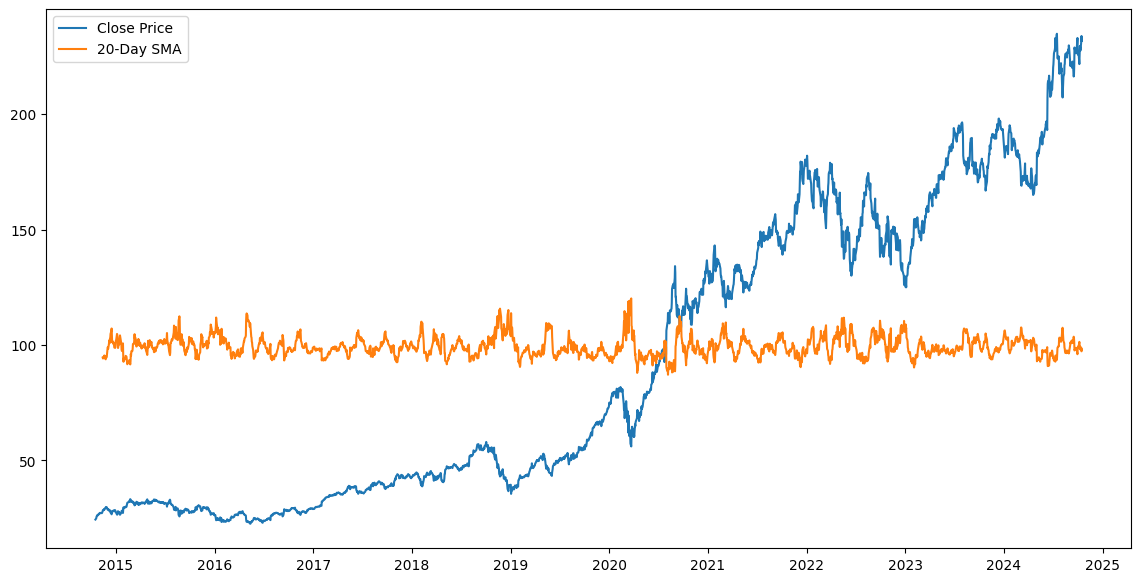

In [116]:
plt.figure(figsize=(14, 7))
plt.plot(sample_stock['Date'], sample_stock['Close'], label='Close Price')
plt.plot(sample_stock['Date'], sample_stock['SMA_20'], label='20-Day SMA')
plt.legend()
plt.show()

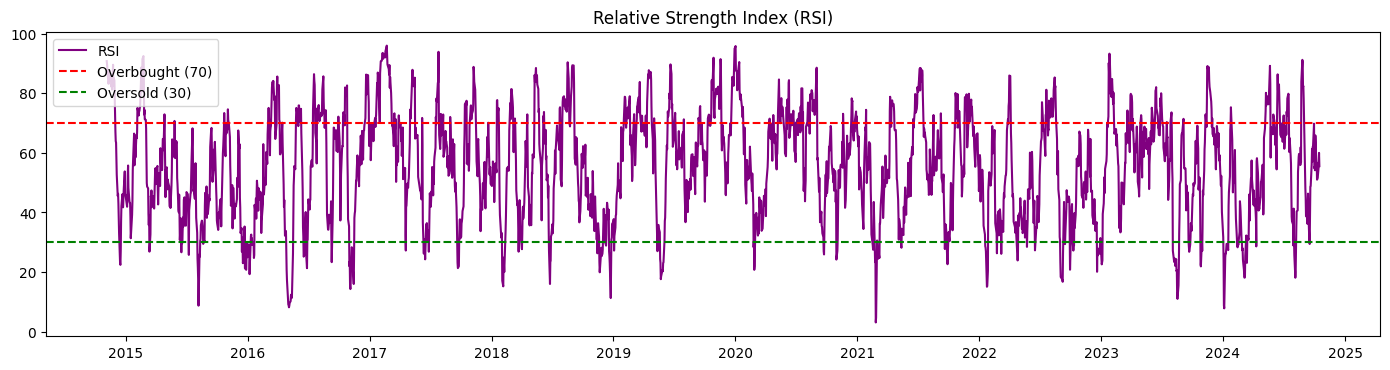

In [117]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.plot(sample_stock['Date'], sample_stock['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title("Relative Strength Index (RSI)")
plt.legend(loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [118]:
# Calculate future 5-day and 10-day returns
data['5_day_return'] = data.groupby('Symbol')['Close'].shift(-5).pct_change(periods=5) * 100
data['10_day_return'] = data.groupby('Symbol')['Close'].shift(-10).pct_change(periods=10) * 100

model_data = data.dropna(subset=['SMA_20', 'RSI', '5_day_return'])


/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_9772/1563139213.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['5_day_return'] = data.groupby('Symbol')['Close'].shift(-5).pct_change(periods=5) * 100
/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_9772/1563139213.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['10_day_return'] = data.groupby('Symbol')['Close'].shift(-10).pct_change(periods=10) * 100


In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define features for individual models
sma_feature = model_data[['SMA_20']]
rsi_feature = model_data[['RSI']]
combined_features = model_data[['SMA_20', 'RSI']]

# Define target variable (5-day returns as an example; you can repeat for 10-day returns)
target = model_data['5_day_return']

In [120]:
model_sma = LinearRegression()
model_sma.fit(sma_feature, target)
predictions_sma = model_sma.predict(sma_feature)
mse_sma = mean_squared_error(target, predictions_sma)
r2_sma = r2_score(target, predictions_sma)

In [121]:
model_rsi = LinearRegression()
model_rsi.fit(rsi_feature, target)
predictions_rsi = model_rsi.predict(rsi_feature)
mse_rsi = mean_squared_error(target, predictions_rsi)
r2_rsi = r2_score(target, predictions_rsi)

In [122]:
model_combined = LinearRegression()
model_combined.fit(combined_features, target)
predictions_combined = model_combined.predict(combined_features)
mse_combined = mean_squared_error(target, predictions_combined)
r2_combined = r2_score(target, predictions_combined)

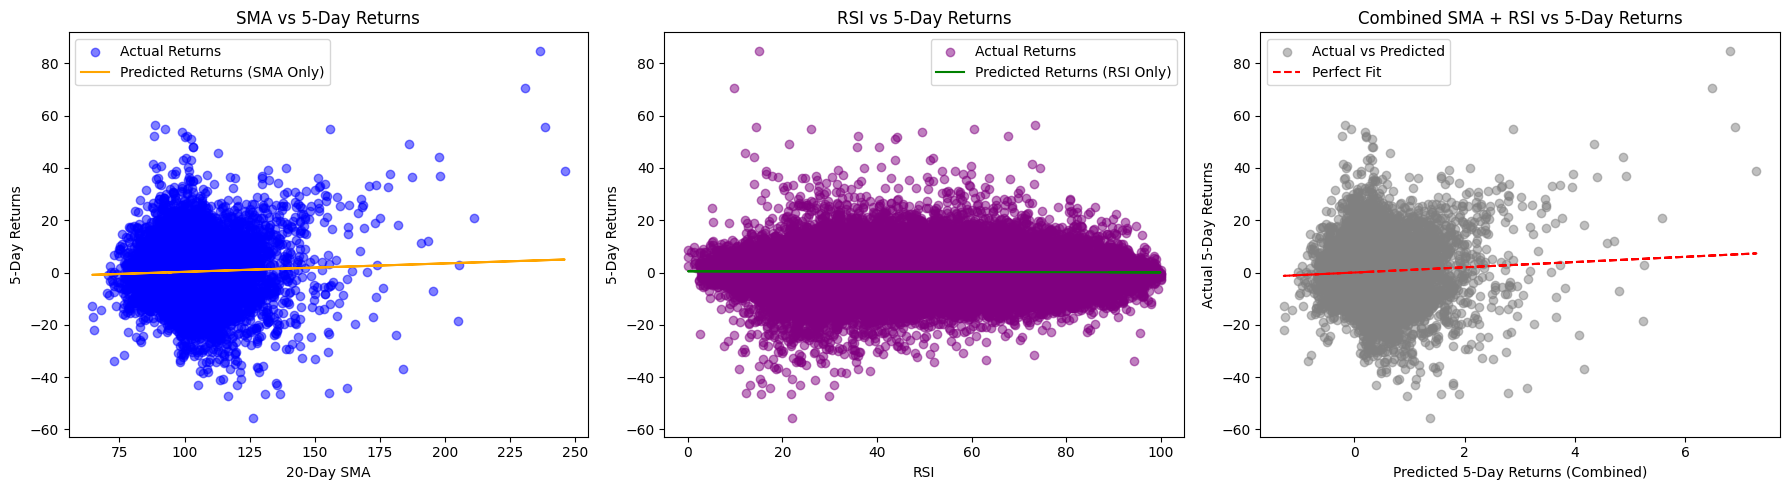

In [123]:
# Set up the figure for multiple plots
plt.figure(figsize=(18, 5))

# SMA Only Model Plot
plt.subplot(1, 3, 1)
plt.scatter(sma_feature, target, color='blue', alpha=0.5, label='Actual Returns')
plt.plot(sma_feature, predictions_sma, color='orange', label='Predicted Returns (SMA Only)')
plt.title('SMA vs 5-Day Returns')
plt.xlabel('20-Day SMA')
plt.ylabel('5-Day Returns')
plt.legend()

# RSI Only Model Plot
plt.subplot(1, 3, 2)
plt.scatter(rsi_feature, target, color='purple', alpha=0.5, label='Actual Returns')
plt.plot(rsi_feature, predictions_rsi, color='green', label='Predicted Returns (RSI Only)')
plt.title('RSI vs 5-Day Returns')
plt.xlabel('RSI')
plt.ylabel('5-Day Returns')
plt.legend()

# Combined Model Plot
plt.subplot(1, 3, 3)
plt.scatter(predictions_combined, target, color='grey', alpha=0.5, label='Actual vs Predicted')
plt.plot(predictions_combined, predictions_combined, color='red', linestyle='--', label='Perfect Fit')
plt.title('Combined SMA + RSI vs 5-Day Returns')
plt.xlabel('Predicted 5-Day Returns (Combined)')
plt.ylabel('Actual 5-Day Returns')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [124]:
print("SMA Only Model - MSE:", mse_sma, ", R^2:", r2_sma)
print("RSI Only Model - MSE:", mse_rsi, ", R^2:", r2_rsi)
print("Combined Model (SMA + RSI) - MSE:", mse_combined, ", R^2:", r2_combined)

SMA Only Model - MSE: 15.72700423725949 , R^2: 0.0013702501135689493
RSI Only Model - MSE: 15.743079370697851 , R^2: 0.00034951493458867944
Combined Model (SMA + RSI) - MSE: 15.72290812220635 , R^2: 0.001630344298660602


In [125]:
rsi_corr = data['RSI'].corr(data['10_day_return'])
print(rsi_corr)

-0.012488769808375615


In [128]:
columns_to_correlate = ['RSI', 'SMA_20', 'pct_change']  # Add more columns as needed

correlations = {col: data[col].corr(data['5_day_return']) for col in columns_to_correlate}

for col, corr_value in correlations.items():
    print(f"Correlation between {col} and 10_day_return: {corr_value:.4f}")

Correlation between RSI and 10_day_return: -0.0186
Correlation between SMA_20 and 10_day_return: 0.0370
Correlation between pct_change and 10_day_return: -0.0090
